# 손실곡선
사이킷 런에서 제공하는 머신러닝 알고리즘들은 매개변수를 조정하고 훈련하는 과정을 반복했다.  
반면 딥러닝에서는 모델의 구조를 직접 만드는 느낌이 강하다.  
층을 추가하고 층에 있는 뉴런의 개수와 활성화 함수를 결정하는 작업을 거쳐야 했다.  
때문에 프로그래머에게는 딥러닝이 좀 더 친숙하게 느껴질 수 있다.

# 손실 곡선
노트북의 코드 셀은

In [11]:
# 데이터 적재, 훈련세트와 검증세트로 분할
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size = 0.2, random_state = 42)

모델 만들기  
단, 그 전에 모델을 만드는 함수를 정의

In [12]:
def model_fn(a_layer = None):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))
  model.add(keras.layers.Dense(100, activation = 'relu'))
  if a_layer:
    model.add(a_layer)
  model.add(keras.layers.Dense(10, activation= 'softmax'))
  return model

함수로 모델을 만들었다.  
이것을 출력해보자.  

In [13]:
model = model_fn()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               78500     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(loss='sparse_categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_scaled, train_target, epochs = 5, verbose = 0)

verbose 매개변수는 훈련과정 출력을 조절한다, 기본 값은 1이고  
에포크 진행막대와 손실 지표가 출력된다.  
2로 할 경우, 진행 막대를 빼고 출력한다.  
0으로 할 경우, 훈련 과정을 나타내지 않는다.  


In [15]:
# history 객체의 값을 확인, 내용물은 손실과 정확도로 구성된 딕셔너리
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


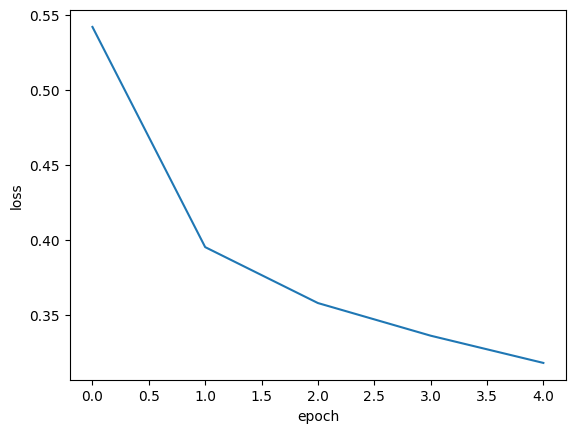

In [16]:
# 손실 출력
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

5개의 에포크가 0에서부터 4까지  손실된 값이 표현된다.

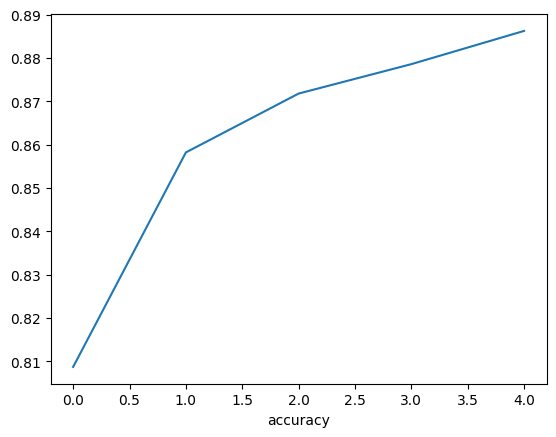

In [17]:
# 정확도 출력
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.xlabel('accuracy')
plt.show()

에포크가 진행될 수록 정확도가 올라간다.  
에포크마다 손실이 감소하고 정확도가 올라가는 것을 볼 수 있다.

---
테스트  
에포크가 늘어날수록 손실이 감소하고 정확도가 향상된다.  
그렇다면 무작정 늘려볼까?

<function matplotlib.pyplot.show(close=None, block=None)>

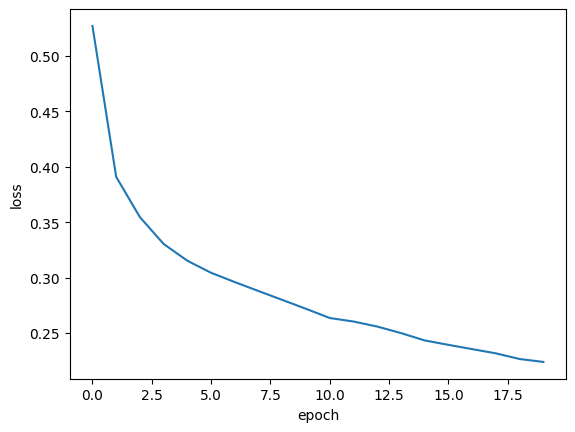

In [18]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs = 20, verbose = 0)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show

확실히 손실이 아주 잘 감소한다.  
그런데 뭔가 잊고 있는게 있지 않은가?

# 검증 손실
확률적 경사하강법을 사용할 때 과대/과소적합과 에포크 사이의 관계를 알아봤다.  
에포크에 따른 과대적합과 과소적합을 파악하려면 훈련 세트에 대한 점수뿐만 아니라  
검증에 대한 점수도 필요하다.  
즉, 훈련세트와 검증세트의 그래프를 같이 그려보아야 한다.  

In [19]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_scaled, train_target, epochs = 20, verbose =0, validation_data = (val_scaled, val_target))

In [20]:
# 변환된 history.history 딕셔너리에 어떤 값이 들어있는지 키를 확인해보자
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


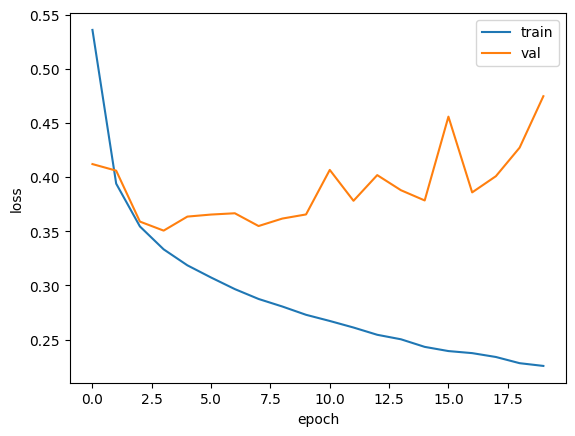

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()


초기에 검증손실이 감소하다가 다시 상승하기 시작한다.  
훈련 손실은 꾸준히 감소하기에 전형적인 과대적합 모델이 만들어진다.  
검증 손실이 상승하는 시점을 가능한 뒤로 늦추면 검증 세트에 대한 손실이 줄어들 뿐만 아니라 검증세트에 대한 정확도도 증가할 것이다.  

---
과대적합을 막기 위해, 규제 방식 대신 신경망에 특화된 규제 방법을 해야한다.  
다만 지금은 옵티마이저 하이퍼파라미터를 조정하여 과대적합을  
완화시킬 수 있는지 알아보자  


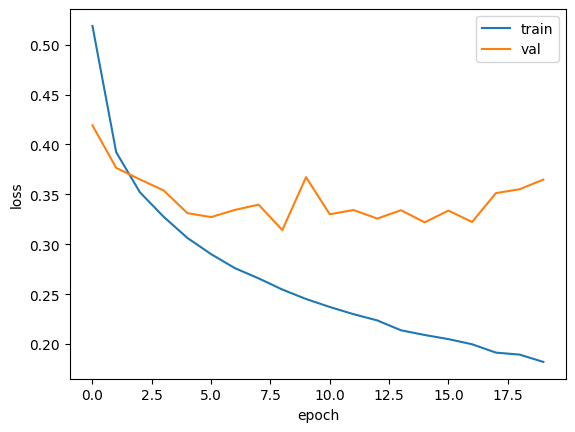

In [22]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()


과대적합이 훨씬 줄었다.  
검증 손실 그래프에 여전히 요동이 남아있지만 열 번째 에포크까지 지점까지는 얼추 감소하는 듯 하다.  
더 나은 손실 곡선을 얻고자 한다면 학습률을 조정해서 다시 시도해 볼 수 있다.  
그러나 지금은 여기까지만 하자

# 드롭아웃